In [1]:
import numpy as np 
import pandas as pd 
import scanpy as sc 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
base_dir = '/ix/djishnu/shared/djishnu_kor11/training_data_2025/'
adata = sc.read_h5ad(base_dir + 'slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

### Run COVET

In [1]:
import scenvi 

In [5]:
adata.obsm['COVET'], adata.obsm['COVET_SQRT'], adata.uns['CovGenes'] = scenvi.compute_covet(adata)

In [ ]:
np.save('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_lymphnode_slideseq/COVET.npy', adata.obsm['COVET'])
np.save('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_lymphnode_slideseq/COVET_SQRT.npy', adata.obsm['COVET_SQRT'])
np.save('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_lymphnode_slideseq/CovGenes.npy', adata.uns['CovGenes'])

### Train COVET

In [4]:
import sys
sys.path.append('../../src')

from spaceoracle.tools.network import RegulatoryFactory
from spaceoracle.gene_factory import GeneFactory
from spaceoracle.astronomer import Astronaut

co_grn = RegulatoryFactory(
    colinks_path=base_dir + 'slideseq_mouse_lymphnode_colinks.pkl',
    annot='cell_type_int'
)

In [5]:
sp_maps = np.load('/ix/djishnu/shared/djishnu_kor11/covet_outputs/mouse_lymphnode_slideseq/COVET.npy')
feature_key = 'COVET'
adata.obsm['COVET'] = sp_maps
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred', 'COVET'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [9]:
neil = Astronaut(
    adata=adata,
    annot='cell_type_int', 
    max_epochs=100, 
    learning_rate=5e-3, 
    spatial_dim=64,
    batch_size=512,
    grn=co_grn,
    radius=800,
    contact_distance=50,
    save_dir='/ix/djishnu/shared/djishnu_kor11/covet_runs/mouse_lymphnode_slideseq'
)


In [10]:
neil.run(sp_maps_key='COVET')

Using COVET as spatial maps
Fitting Cep68 with 252 modulators
	26 Transcription Factors
	174 Ligand-Receptor Pairs
	52 TranscriptionFactor-Ligand Pairs
0: x.xxxx | 0.1114
1: x.xxxx | 0.1800
2: 0.4804 | 0.5147
3: x.xxxx | 0.1183
4: x.xxxx | 0.0748
5: 0.3407 | 0.3093
6: x.xxxx | 0.1785
Using COVET as spatial maps
Fitting Chrng with 220 modulators
	14 Transcription Factors
	174 Ligand-Receptor Pairs
	32 TranscriptionFactor-Ligand Pairs
0: x.xxxx | -0.0000
1: 1.0000 | 1.0000
2: 1.0000 | 1.0000
3: 1.0000 | 1.0000
4: 1.0000 | 1.0000
5: x.xxxx | -0.0000
6: 1.0000 | 1.0000
Using COVET as spatial maps
Fitting Klrc2 with 237 modulators
	20 Transcription Factors
	174 Ligand-Receptor Pairs
	43 TranscriptionFactor-Ligand Pairs
0: x.xxxx | 0.0168
1: x.xxxx | 0.1045
2: 1.0000 | 1.0000
3: 1.0000 | 1.0000
4: 1.0000 | 1.0000
5: 1.0000 | 1.0000
6: x.xxxx | 0.3374
Using COVET as spatial maps
Fitting Mad2l1 with 242 modulators
	22 Transcription Factors
	174 Ligand-Receptor Pairs
	46 TranscriptionFactor-Lig

KeyboardInterrupt: 

In [ ]:
gf = GeneFactory.from_json(
    adata=adata, 
    json_path=base_dir + 'covet_runs/mouse_lymphnode_slideseq' + '/run_params.json', 
)

gf.load_betas()

gf.genome_screen(
    save_to=base_dir + '/genome_screens/slideseq_mouse_lymphnode_COVET',
    n_propagation = 4,
    priority_genes = [
        'Il2', 'Il4',  'Il6st', 'Gzma', 'Il2ra', 
        'Cxcr4', 'Ccr4', 'Il4ra', 'Gata3', 'Gata2', 
        'Pax5', 'Stat4', 'Foxp3', 'Bcl6', 'Ccl20', 
        'Ccr7', 'Il21r', 'Il21', 'Ccl5'
    ]
)

### Compare transitions

In [3]:
covet_dir = '/ix/djishnu/shared/djishnu_kor11/genome_screens/mouse_lymphnode_slideseq_COVET/'
cnn_dir = '/ix/djishnu/shared/djishnu_kor11/genome_screens/slideseq_mouse_lymphnode/'

In [10]:
color_dict = {
    'B': 'gray',
    'Resting T': 'gray',
    'Tfh': 'gray',
    'CD8+ T': 'gray',
    'Treg': 'gray',
    'Th2': 'gray',
    'DC': 'gray'
}

In [5]:
ligands = ['Il2', 'Il4', 'Ccl5', 'Il15', 'Cxcl13', 'Lgals9']
receptors = ['Il2ra', 'Ccr4', 'Il6st', 'Cxcr4', 'Il4ra', 'Cxcr5']
tfs = ['Gata3', 'Pax5', 'Bcl6', 'Prdm1', 'Foxp3', 'Stat4']
rand_tfs = ['Gata3', 'Cux2', 'Pten', 'Zkscan3', 'Fosl2', 'Tfcp2']

In [23]:
from tqdm import tqdm
ko_data = []

files = rand_tfs

for kotarget in tqdm(files):
    data = pd.read_parquet(f'{covet_dir}/{kotarget}_4n_0x.parquet')
    data = data.loc[adata.obs_names] - adata.to_df(layer='imputed_count')
    data = data.join(adata.obs.cell_type).groupby('cell_type').mean().abs().mean(axis=1)

    ds = {}
    for k, v in data.sort_values(ascending=False).to_dict().items():
        ds[k] = v

    data = pd.DataFrame.from_dict(ds, orient='index')
    data.columns = [kotarget]
    ko_data.append(data)

100%|██████████| 6/6 [00:56<00:00,  9.40s/it]


In [24]:
ko_concat = pd.concat(ko_data, axis=1)
ko_concat.head()

,Gata3,Cux2,Pten,Zkscan3,Fosl2,Tfcp2
Treg,0.000819,6.673407e-11,0.000075,0.000004,1.999125e-05,1.706035e-06
Th2,0.000671,5.508086e-11,0.000007,0.000005,9.700991e-06,5.495831e-11
Tfh,0.000456,6.011701e-11,0.000017,0.000004,9.299345e-06,6.891989e-07
DC,0.000414,7.712711e-12,0.000012,0.000007,5.042989e-11,8.293215e-12
B,0.000201,1.476407e-12,0.000024,0.000013,3.711420e-05,3.518607e-06


In [25]:
from sklearn.preprocessing import StandardScaler

ko_concat_norm = pd.DataFrame(
    StandardScaler().fit_transform(ko_concat), 
    # ko_concat, 
    index=ko_concat.index, 
    columns=ko_concat.columns
)

Text(0.5, 1.0, 'Magnitude of KO effect (COVET betas)')

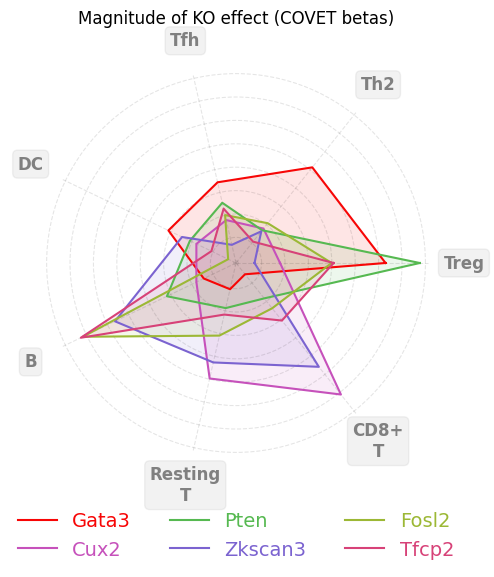

In [26]:
import warnings
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 1, 
        figsize=(5, 5), dpi=100, 
        subplot_kw={'projection': 'polar'})
colors = ["#f70606",
"#c651bb",
"#56b951",
"#7b63d0",
"#9cb835",
"#d74278",
"#57be93",
"#cf4a35",
"#49b9d3",
"#e08830",
"#6481c6",
"#c9a841",
"#9b508b",
"#5b8225",
"#d68ecd",
"#3f7c4a",
"#b85865",
"#7c722c",
"#e49373",
"#9e622e"]
for i, col in enumerate(files):
    values = ko_concat_norm[col].values.tolist()
    values += values[:1]  # Repeat first value to close polygon
    
    angles = np.linspace(0, 2*np.pi, len(ko_concat_norm.index), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # Repeat first angle to close polygon

    ax.plot(angles, values, '-', linewidth=1.5, 
            label=col, 
            color=colors[i]
        )
    ax.fill(angles, values, alpha=0.1, 
        edgecolor='black', 
        color=colors[i], 
        linewidth=0.5, hatch='')
    

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(
        ko_concat_norm.index.str.replace(' ', '\n'), size=12,
        fontweight='bold',
    )

    for t in ax.get_xticklabels():
        txt = t.get_text()
        t.set_color(color_dict[txt.replace('\n', ' ')])
        t.set_fontweight('bold')
        t.set_bbox(dict(boxstyle="round,pad=0.3", 
            fc=color_dict[txt.replace('\n', ' ')], ec="gray", alpha=0.1))
    ax.set_rlabel_position(0)
    ax.tick_params(pad=15)

    ax.grid(True, alpha=0.1, linestyle='--', color='black')
    ax.set_yticklabels(labels=ax.get_yticks(), size=5)

    ax.spines['polar'].set_visible(False)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.1), 
        loc='upper center', ncol=3, frameon=False, fontsize=14)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())
    ax.set_rlabel_position(35)
    ax.set_yticklabels([])

plt.title('Magnitude of KO effect (COVET betas)')